In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import time
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler
from torch.utils.data import sampler
import numpy as np
import matplotlib.colors as mcolors

In [2]:
# Hyperparameters
RANDOM_SEED = 49
LEARNING_RATE = 0.0005
BATCH_SIZE = 256
NUM_EPOCHS = 30
NUM_CLASSES = 10

In [7]:
def get_dataloaders_mnist(batch_size, num_workers=0,
                          train_transforms=None, test_transforms=None):
    if train_transforms is None:
        train_transforms = transforms.ToTensor()
    if test_transforms is None:
        test_transforms = transforms.ToTensor()
    train_dataset = datasets.MNIST(root='data',
                                  train=True,
             transform=train_transforms,download=True)
    valid_dataset = datasets.MNIST(root='data',
                                   train=True,
                                   transform=test_transforms)
    test_dataset = datasets.MNIST(root='data',
                                  train=False,
                                  transform=test_transforms)
    train_loader = DataLoader(dataset=train_dataset,
                              batch_size=batch_size,
                              num_workers=num_workers,
                              shuffle=True)
    test_loader = DataLoader(dataset=test_dataset,
                             batch_size=batch_size,
                             num_workers=num_workers,
                             shuffle=False)
    return train_loader, valid_dataset, test_loader
train_loader, valid_loader, test_loader = get_dataloaders_mnist(batch_size=BATCH_SIZE, num_workers=2)

In [9]:
print('Training Set:\n')
for images, labels in train_loader:
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break

Training Set:

Image batch dimensions: torch.Size([64, 1, 28, 28])
Image label dimensions: torch.Size([64])
tensor([8, 2, 3, 1, 7, 6, 6, 6, 6, 2])


In [11]:
import torch
import torchvision as tv
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import save_image

num_epochs = 10
batch_size = 64
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])     

trainset = tv.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset  = tv.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=4)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Autoencoderv3(nn.Module):
    def __init__(self):
        super(Autoencoderv3, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=5),
            nn.Dropout2d(p=0.1),
            nn.ReLU(True),
            nn.Conv2d(4, 8, kernel_size=5),
            nn.Dropout2d(p=0.1),
            nn.ReLU(True),
            nn.Flatten(),
            nn.Linear(3200, 10)
        )
        self.softmax = nn.Softmax(dim=1)
        self.decoder = nn.Sequential(
            nn.Linear(10, 400),
            nn.ReLU(True),
            nn.Unflatten(1, (1, 20, 20)),
            nn.Dropout2d(p=0.1),
            nn.ConvTranspose2d(1, 10, kernel_size=5),
            nn.ReLU(True),
            nn.Dropout2d(p=0.1),
            nn.ConvTranspose2d(10, 1, kernel_size=5)
        )
        
    def forward(self, x):
        out_en = self.encoder(x)
        out = self.softmax(out_en)
        out = self.decoder(out)
        return out, out_en

model = Autoencoderv3().to(device)
distance = nn.MSELoss()
class_loss = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

mse_multp = 0.5
cls_multp = 0.5

model.train()

for epoch in range(num_epochs):
    total_mseloss = 0.0
    total_clsloss = 0.0
    for ind, data in enumerate(dataloader):
        img, labels = data[0].to(device), data[1].to(device)
        output, output_en = model(img)
        loss_mse = distance(output, img)
        loss_cls = class_loss(output_en, labels)
        loss = (mse_multp * loss_mse) + (cls_multp * loss_cls)  # Combine two losses together
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Track this epoch's loss
        total_mseloss += loss_mse.item()
        total_clsloss += loss_cls.item()

    # Check accuracy on test set after each epoch:
    model.eval()   # Turn off dropout in evaluation mode
    acc = 0.0
    total_samples = 0
    for data in testloader:
        # We only care about the 10 dimensional encoder output for classification
        img, labels = data[0].to(device), data[1].to(device)
        _, output_en = model(img)   
        # output_en contains 10 values for each input, apply softmax to calculate class probabilities
        prob = nn.functional.softmax(output_en, dim=1)
        pred = torch.max(prob, dim=1)[1].detach().cpu().numpy()  # Max prob assigned to class 
        acc += (pred == labels.cpu().numpy()).sum()
        total_samples += labels.shape[0]
    model.train()   # Enables dropout back again
    print('epoch [{}/{}], loss_mse: {:.4f}  loss_cls: {:.4f}  Acc on test: {:.4f}'.format(epoch+1, num_epochs, total_mseloss / len(dataloader), total_clsloss / len(dataloader), acc / total_samples))

epoch [1/10], loss_mse: 0.8785  loss_cls: 0.4081  Acc on test: 0.9532
epoch [2/10], loss_mse: 0.8179  loss_cls: 0.1852  Acc on test: 0.9683
epoch [3/10], loss_mse: 0.7779  loss_cls: 0.1355  Acc on test: 0.9745
epoch [4/10], loss_mse: 0.7509  loss_cls: 0.1139  Acc on test: 0.9778
epoch [5/10], loss_mse: 0.7296  loss_cls: 0.0999  Acc on test: 0.9759
epoch [6/10], loss_mse: 0.7107  loss_cls: 0.0913  Acc on test: 0.9793
epoch [7/10], loss_mse: 0.6919  loss_cls: 0.0843  Acc on test: 0.9795
epoch [8/10], loss_mse: 0.6774  loss_cls: 0.0782  Acc on test: 0.9796
epoch [9/10], loss_mse: 0.6681  loss_cls: 0.0742  Acc on test: 0.9811
epoch [10/10], loss_mse: 0.6614  loss_cls: 0.0714  Acc on test: 0.9820


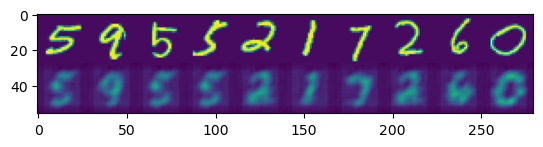

In [13]:
import numpy as np
import matplotlib.pyplot as plt
 
model.eval()
img, labels = list(dataloader)[0]
img = img.to(device)
output, output_en = model(img)
inp = img[0:10, 0, :, :].squeeze().detach().cpu()
out = output[0:10, 0, :, :].squeeze().detach().cpu()
 
 # Just some trick to concatenate first ten images next to each other
inp = inp.permute(1,0,2).reshape(28, -1).numpy()
out = out.permute(1,0,2).reshape(28, -1).numpy()
combined = np.vstack([inp, out])
 
plt.imshow(combined)
plt.show()

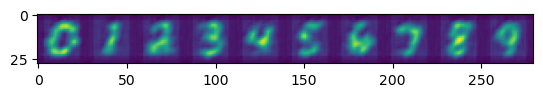

In [14]:
 test_arr = np.zeros([10, 10], dtype = np.float32)
 ind = np.arange(0, 10)
 test_arr[ind, ind] = 1.0
 
 model.eval()
 img = torch.from_numpy(test_arr).to(device)
 out = model.decoder(img)
 out = out[0:10, 0, :, :].squeeze().detach().cpu()
 out = out.permute(1,0,2).reshape(28, -1).numpy()
 plt.imshow(out)
 plt.show()